In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import pandas as pd
import numpy as np
from sglm.helpers import filehelpers as fh, dfhelpers as dfh
from pathlib import Path
from collections import defaultdict
from tqdm.notebook import tqdm, trange
import scipy.stats
import matplotlib.pyplot as plt


In [4]:
base_keys = list({
#                 'gACH':(0,0),
#                 'rDA':(0,0),
                'gDA_ctrl':(0,0),
                'gDA_tet':(0,0),
                'photometrySideInIndexr':(0,0),
                'photometrySideInIndexnr':(0,0),
                'photometrySideInIndexAA':(0,0),
                'photometrySideInIndexAa':(0,0),
                'photometrySideInIndexaA':(0,0),
                'photometrySideInIndexaa':(0,0),
                'photometrySideInIndexAB':(0,0),
                'photometrySideInIndexAb':(0,0),
                'photometrySideInIndexaB':(0,0),
                'photometrySideInIndexab':(0,0),
                }.keys())
shortened_keys = [dfh.shorten_col_name(_) for _ in base_keys]

all_alignment_cols = [
                        'SIAA', 'SIAa', 'SIaA', 'SIaa',
                        'SIAB', 'SIAb', 'SIaB', 'SIab',
                        'SIr', 'SInr', 
                     ]
# base_keys

In [5]:
def get_delta_list(event_srs, event_col, keep_srs):
    
    keep_eg_lst = []
    delta_keep_eg_lst = []

    rdc = []
    entry_num = np.arange(len(event_srs))
    event = np.where(event_srs.values == 1)
    assert len(event) == 1
    event = event[0]
    
    for iev, ev in enumerate(event):
        delta = entry_num - ev
        keep_eg = (delta >= -40)&(delta <= 100)&keep_srs
        delta_keep_eg = delta[keep_eg]
        keep_eg_lst.append(keep_eg)
        delta_keep_eg_lst.append(delta_keep_eg)

    return keep_eg_lst, delta_keep_eg_lst

# full_df = h5_lst[0]


In [16]:
# base_location = Path(r'/Users/josh/Documents/Harvard/GLM/sabatinilab-glm/sglm/outputs')
# base_location = Path(r'C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs')
base_location = Path(r'C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs-old')

# fig_folder_lst = [('Figure_1_2', 'f1*-ft'),
#                   ('Figure_3',   'f3*-ft'),
#                   ('Figure_4_g1',   'f4*-ft'),
#                   ('Figure_4_g2',   'f4*-ft'),
#                   ('Figure_5_g1',   'f5*-ft'),
#                   ('Figure_5_g2',   'f5*-ft'),
#                   ('Figure_5_g5',   'f5*-ft'),
#                  ]
fig_folder_lst = [#('Figure_1_2', 'f1-n*-ft'),
#                   ('Figure_3',   'f3*-ft'),
#                   ('Figure_4_g1',   'f4*-ft'),
#                   ('Figure_4_g2',   'f4*-ft'),
#                   ('Figure_5_g1',   'f5*-ft'),
#                   ('Figure_5_g2',   'f5*-ft'),
#                   ('Figure_5_g5',   'f5*-ft'),
                   ('Figure_7_g1--20_20sft',   'tet*'),
                 ]

for fig_folder in fig_folder_lst:
    print('fig_folder', fig_folder)
    
    load_folder = base_location / Path(fig_folder[0])
    # load_folder = base_location / Path(r'tmp')
    h5_recons_locations = str((load_folder / Path('all') / Path(fig_folder[1]) / Path(r'reconstructs\best_resids_*.h5')).resolve())
    
#     print(h5_recons_locations)
    
#     load_folder = base_location / Path(r'Figure_1_2')
#     # load_folder = base_location / Path(r'tmp')
#     h5_recons_locations = str((load_folder / Path(r'all\f1*-ft\reconstructs\best_resids_*.h5')).resolve())
#     # h5_recons_locations = str((load_folder / Path(r'all/f1*-ft/reconstructs/best_resids_*.h5')).resolve())
#     # load_folder = base_location / Path(r'Figure_3')
#     # h5_beta_locations = str((load_folder / Path(r'all\f3*-ft\reconstructs\best_resids_*.h5')).resolve())
#     # load_folder = base_location / Path(r'Figure_4_g1')
#     # h5_beta_locations = str((load_folder / Path(r'all\f4*-ft\reconstructs\best_resids_*.h5')).resolve())
#     # load_folder = base_location / Path(r'Figure_4_g2')
#     # h5_beta_locations = str((load_folder / Path(r'all\f4*-ft\reconstructs\best_resids_*.h5')).resolve())
#     # load_folder = base_location / Path(r'Figure_5_g1')
#     # h5_beta_locations = str((load_folder / Path(r'all\f5*-ft\reconstructs\best_resids_*.h5')).resolve())
#     # load_folder = base_location / Path(r'Figure_5_g2')
#     # h5_beta_locations = str((load_folder / Path(r'all\f5*-ft\coefs\*_best_coeffs.h5')).resolve())
#     # load_folder = base_location / Path(r'Figure_5_g5')
#     # h5_beta_locations = str((load_folder / Path(r'all\f5*-ft\coefs\*_best_coeffs.h5')).resolve())

    out_folder = base_location / Path(r'final_outputs_rev-msesplt')

    out_loc = str((out_folder).resolve())
    h5_recons_locations = glob.glob(h5_recons_locations)

    fh.create_folder_if_not_exists(out_loc)
    
    h5_lst = defaultdict(dict)
#     run_id_dct = defaultdict(dict)


    for ih5, h5_coef_fn in enumerate(h5_recons_locations):
        h5f = pd.HDFStore(h5_coef_fn)
        h5fk = h5f.keys()
        for ik, key in enumerate(h5fk):
            key = key.replace('/', '')
#             resp = key.split('_')[0] # TODO: FIX NAMING ASSUMPTIONS -- REMOVED FOR NOW
            resp = '_'.join(key.split('_')[:2]) # TODO: FIX NAMING ASSUMPTIONS -- REMOVED FOR NOW
            model_version = '_'.join(key.split('_')[3:]).split('_run_num')[0]
            

            if 'run_num' in key and 'run_num__0' not in key: #and 'run_num__1' not in key:
                continue
            if 'base_simple' not in model_version and 'base_words' not in model_version and '_to_' not in model_version and 'basis' not in key:
                continue
            
#             print('model_version', model_version)
            
#             print(key, model_version)
#             print(f'ih5, ik, model_version, key, h5_coef_fn - {ih5}, {ik}, {model_version}, {key}, {h5_coef_fn}')

            y_col = '_'.join(key.split('_')[:2]).replace(r'/', r'')
            
            h5_df = pd.read_hdf(h5f, key)

            h5_df.columns = [dfh.shorten_col_name(_) for _ in h5_df.columns]

            if 'dfrel_basis' != key.replace('/', ''):
                h5_df.columns = [_.split('_')[0] for _ in h5_df.columns]
                h5_df['true'] = h5_lst[ih5]['dfrel'][y_col]

                h5_df['file_num'] = h5_lst[ih5]['dfrel']['file_num']

                h5_df['dupe'] = h5_lst[ih5]['dfrel']['dupe']
                h5_df['wi_trial_keep'] = h5_lst[ih5]['dfrel']['wi_trial_keep']

                h5_lst[ih5][key] = h5_df
            else:
                h5_lst[ih5]['dfrel'] = h5_df

#     for k in h5_lst:
#         for kk in h5_lst[k]:
#             print(k, kk)



    for ih5 in h5_lst:
#     for y_col in ['gACH', 'rDA', 'gDA']:
#             fig,axes = plt.subplots(5,2,figsize=(10,30))

        for key in h5_lst[ih5]:
#         for y_col in ['gACH', 'rDA', 'gDA']:
#         for ih5 in h5_lst:
            if key == 'dfrel':
                continue
            
            mse_ac = {}
            combo_rdc = {}
            for iac, alignment_col in enumerate(all_alignment_cols):
    #                 ic, ir = iac%2, iac//2
    #                 ax = axes[ir, ic]

                
                resp = '_'.join(key.split('_')[:2]).replace('/', '')
                model_version = '_'.join(key.split('_')[2:]).split('_run_num')[0]
                model_version = model_version.replace('5_base_words_gDA_to_gACH', '5_base_words_rDA_to_gACH')
                print(key, alignment_col)
                print(model_version)
#                 break
#             break
#         break
#     break
                y_col = '_'.join(key.split('_')[:2]).replace(r'/', r'')
                
                dupe = h5_lst[ih5]['dfrel']['dupe']
                dfrel_basis = h5_lst[ih5]['dfrel'].loc[~dupe]
                dfrel_basis_run = h5_lst[ih5][key].loc[~dupe]

                print('Pulling delta list')
                keep_rows, assoc_deltas = get_delta_list(dfrel_basis[alignment_col], alignment_col, ((dfrel_basis_run['holdout']==1)).astype(bool))
                rdc_lst = defaultdict(list)
                for entry_num in trange(len(keep_rows)):
                    keep_row_single = keep_rows[entry_num]
                    deltas = assoc_deltas[entry_num]
                    rdc_df = dfrel_basis_run.loc[keep_row_single].set_index(deltas)

                    if rdc_df['file_num'].nunique() > 1:
                        continue

                    reconstruction_data_list = []

                    for bootstrap_col in ['true', 'pred']:
                        rdc_lst[bootstrap_col].append(rdc_df[[bootstrap_col]])

                print('keys', rdc_lst.keys())
                
                
                
                t, p = pd.concat(rdc_lst['true'], axis=1).sort_index(), pd.concat(rdc_lst['pred'], axis=1).sort_index()
                dffsq = np.square(t.values - p.values)
                mse_ac[alignment_col] = np.sum(dffsq[np.where(~np.isnan(dffsq))])/np.sum(~np.isnan(dffsq))
                
                
                if 'SIAB' == alignment_col:
                    print('Error: Problem with SIAB')
                    continue

                seed = np.random.randint(1000000000)
                for bootstrap_col in (rdc_lst):
                    tmp_rdc = pd.concat(rdc_lst[bootstrap_col], axis=1).sort_index()

                    reconstruction_data_list = []
                    for delta in (tmp_rdc.index):
                        row = tmp_rdc.loc[delta].dropna().values
                        bs = scipy.stats.bootstrap((row,), np.mean, n_resamples=9999,
    #                     bs = scipy.stats.bootstrap((row,), np.mean, n_resamples=1000,
                                                   batch=None, vectorized=True, paired=False,
                                                   axis=0, confidence_level=0.95, method='BCa',
                                                   random_state=seed)

                        mn_val = row.mean()
                        rtup = (bootstrap_col, delta, bs.confidence_interval.low, mn_val, bs.confidence_interval.high)

                        reconstruction_data_list.append(rtup)

                    tmp_combo_rdc = pd.DataFrame(reconstruction_data_list, columns=['basis_column', 'delta', 'lb', 'mn', 'ub']).set_index('delta')
                    combo_rdc[f'{alignment_col}_{bootstrap_col}'] = tmp_combo_rdc.drop('basis_column',axis=1)
            
            combo_rdc = pd.concat(combo_rdc, axis=1)
            combo_rdc.columns = ['_'.join(_).replace('_true_', '_T_').replace('_pred_', '_P_') for _ in combo_rdc.columns]
            combo_rdc.to_csv(str((Path(out_loc) / f'{load_folder.parts[-1]}-reconstruct-{y_col}={model_version}.csv').resolve()))
            
            import json
            with open(str((Path(out_loc) / f'{load_folder.parts[-1]}-mse_seg-{y_col}={model_version}.json').resolve()), 'w') as f:
                json.dump(mse_ac, f)

fig_folder ('Figure_7_g1--20_20sft', 'tet*')
gDA_ctrl_0_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIAA
0_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/1282 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_ctrl_0_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIAa
0_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/237 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_ctrl_0_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIaA
0_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/130 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_ctrl_0_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIaa
0_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/270 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_ctrl_0_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIAB
0_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/24 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Error: Problem with SIAB
gDA_ctrl_0_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIAb
0_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/143 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_ctrl_0_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIaB
0_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/250 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_ctrl_0_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIab
0_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/96 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_ctrl_0_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIr
0_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/1686 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_ctrl_0_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SInr
0_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/746 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_ctrl_0_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIAA
0_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/1282 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_ctrl_0_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIAa
0_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/237 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_ctrl_0_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIaA
0_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/130 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_ctrl_0_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIaa
0_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/270 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_ctrl_0_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIAB
0_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/24 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Error: Problem with SIAB
gDA_ctrl_0_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIAb
0_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/143 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_ctrl_0_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIaB
0_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/250 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_ctrl_0_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIab
0_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/96 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_ctrl_0_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIr
0_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/1686 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_ctrl_0_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SInr
0_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/746 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_tet_1_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIAA
1_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/1282 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_tet_1_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIAa
1_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/237 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_tet_1_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIaA
1_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/130 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_tet_1_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIaa
1_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/270 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_tet_1_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIAB
1_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/24 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Error: Problem with SIAB
gDA_tet_1_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIAb
1_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/143 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_tet_1_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIaB
1_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/250 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_tet_1_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIab
1_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/96 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_tet_1_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIr
1_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/1686 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_tet_1_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SInr
1_0_base_simple_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/746 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_tet_1_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIAA
1_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/1282 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_tet_1_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIAa
1_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/237 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_tet_1_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIaA
1_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/130 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_tet_1_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIaa
1_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/270 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_tet_1_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIAB
1_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/24 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
Error: Problem with SIAB
gDA_tet_1_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIAb
1_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/143 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_tet_1_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIaB
1_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/250 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_tet_1_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIab
1_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/96 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_tet_1_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SIr
1_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/1686 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])
gDA_tet_1_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0_run_num__0 SInr
1_1_base_words_max_iter10000__fit_interceptFalse__alpha0____0__l1_ratio0____0
Pulling delta list


  0%|          | 0/746 [00:00<?, ?it/s]

keys dict_keys(['true', 'pred'])


In [17]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [18]:
combo_rdc

,SIAA_T_lb,SIAA_T_mn,SIAA_T_ub,SIAA_P_lb,SIAA_P_mn,SIAA_P_ub,SIAa_T_lb,SIAa_T_mn,SIAa_T_ub,SIAa_P_lb,...,SIr_T_ub,SIr_P_lb,SIr_P_mn,SIr_P_ub,SInr_T_lb,SInr_T_mn,SInr_T_ub,SInr_P_lb,SInr_P_mn,SInr_P_ub
delta,,,,,,,,,,,,,,,,,,,,,
-40,-0.297181,-0.242539,-0.185487,-0.204845,-0.194142,-0.184116,-0.374288,-0.251713,-0.130848,-0.220319,...,-0.232700,-0.232099,-0.217034,-0.204359,-0.468925,-0.383061,-0.296780,-0.275034,-0.246267,-0.221267
-39,-0.304776,-0.247322,-0.187753,-0.224511,-0.213157,-0.202941,-0.341673,-0.220444,-0.095977,-0.245443,...,-0.255559,-0.244395,-0.231218,-0.219683,-0.433197,-0.346679,-0.258497,-0.276316,-0.250691,-0.229269
-38,-0.299107,-0.242606,-0.184319,-0.245185,-0.233569,-0.222773,-0.371190,-0.244398,-0.118280,-0.244943,...,-0.271965,-0.262175,-0.249219,-0.237582,-0.459667,-0.372232,-0.286379,-0.265879,-0.243742,-0.226939
-37,-0.276498,-0.221402,-0.165272,-0.253797,-0.241885,-0.231796,-0.246238,-0.109172,0.027900,-0.242488,...,-0.255094,-0.259683,-0.247603,-0.236862,-0.387822,-0.296763,-0.207966,-0.250607,-0.232655,-0.216973
-36,-0.274152,-0.216443,-0.157538,-0.249688,-0.238376,-0.227568,-0.154218,-0.002664,0.149296,-0.235021,...,-0.248117,-0.248802,-0.237873,-0.227923,-0.324772,-0.234713,-0.147317,-0.244625,-0.226673,-0.209690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,-0.094564,-0.014894,0.071179,0.060646,0.096728,0.136134,-0.143467,0.017130,0.231693,0.028959,...,0.054520,0.057009,0.090611,0.125295,-0.049952,0.046817,0.152728,0.024637,0.067866,0.119606
97,-0.074345,0.007123,0.089779,0.058507,0.095096,0.132470,-0.255659,-0.079271,0.122045,-0.000218,...,0.067054,0.054567,0.088235,0.122346,-0.089580,0.005754,0.112113,0.006812,0.047626,0.095261
98,-0.050684,0.027224,0.108590,0.056116,0.090818,0.129673,-0.275517,-0.116679,0.055563,-0.026865,...,0.073247,0.051088,0.084473,0.118947,-0.112531,-0.019139,0.080735,-0.001907,0.037194,0.081578


In [19]:
# for k in h5_lst:
#     for kk in h5_lst[k]:
#         print(k, kk)
# #         display(h5_lst[k][kk])
# #     break

In [20]:
# [len(h5_lst['dfrel'][_]) for _ in range(len(h5_lst['dfrel']))], [len(h5_lst[y_col][_]) for _ in range(len(h5_lst[y_col]))]

In [21]:
# len(dupe), len(h5_lst[y_col][i])

<AxesSubplot:xlabel='delta'>

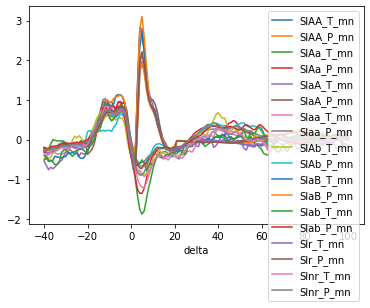

In [22]:
combo_rdc[[_ for _ in combo_rdc.columns if '_mn' in _]].plot()

In [ ]:
y_col, model_version

In [ ]:
# run_id_dct[y_col]

In [ ]:
# # base_location = Path(r'/Users/josh/Documents/Harvard/GLM/sabatinilab-glm/sglm/outputs')
# base_location = Path(r'C:\Users\Josh\Documents\GitHub\sabatinilab-glm\sglm\outputs')

# fig_folder_lst = [#('Figure_1_2', 'f1*-ft'),
#                   #('Figure_3',   'f3*-ft'),
#                   #('Figure_4_g1',   'f4*-ft'),
#                   ('Figure_4_g2',   'f4*-ft'),
#                   #('Figure_5_g1',   'f5*-ft'),
#                   #('Figure_5_g2',   'f5*-ft'),
#                   #('Figure_5_g5',   'f5*-ft'),
#                  ]

# for fig_folder in fig_folder_lst:
#     print('fig_folder', fig_folder)
    
#     load_folder = base_location / Path(fig_folder[0])
#     # load_folder = base_location / Path(r'tmp')
#     h5_recons_locations = str((load_folder / Path('all') / Path(fig_folder[1]) / Path(r'reconstructs\best_resids_*.h5')).resolve())
    
#     print(h5_recons_locations)
    
# #     load_folder = base_location / Path(r'Figure_1_2')
# #     # load_folder = base_location / Path(r'tmp')
# #     h5_recons_locations = str((load_folder / Path(r'all\f1*-ft\reconstructs\best_resids_*.h5')).resolve())
# #     # h5_recons_locations = str((load_folder / Path(r'all/f1*-ft/reconstructs/best_resids_*.h5')).resolve())
# #     # load_folder = base_location / Path(r'Figure_3')
# #     # h5_beta_locations = str((load_folder / Path(r'all\f3*-ft\reconstructs\best_resids_*.h5')).resolve())
# #     # load_folder = base_location / Path(r'Figure_4_g1')
# #     # h5_beta_locations = str((load_folder / Path(r'all\f4*-ft\reconstructs\best_resids_*.h5')).resolve())
# #     # load_folder = base_location / Path(r'Figure_4_g2')
# #     # h5_beta_locations = str((load_folder / Path(r'all\f4*-ft\reconstructs\best_resids_*.h5')).resolve())
# #     # load_folder = base_location / Path(r'Figure_5_g1')
# #     # h5_beta_locations = str((load_folder / Path(r'all\f5*-ft\reconstructs\best_resids_*.h5')).resolve())
# #     # load_folder = base_location / Path(r'Figure_5_g2')
# #     # h5_beta_locations = str((load_folder / Path(r'all\f5*-ft\coefs\*_best_coeffs.h5')).resolve())
# #     # load_folder = base_location / Path(r'Figure_5_g5')
# #     # h5_beta_locations = str((load_folder / Path(r'all\f5*-ft\coefs\*_best_coeffs.h5')).resolve())

#     out_folder = base_location / Path(r'final_outputs')

#     out_loc = str((out_folder).resolve())
#     h5_recons_locations = glob.glob(h5_recons_locations)


#     h5_lst = defaultdict(list)
#     run_id_dct = defaultdict(list)


#     for h5_coef_fn in h5_recons_locations:
#         h5f = pd.HDFStore(h5_coef_fn)
#         h5fk = h5f.keys()
#         for key in h5fk:

#             resp = key.split('_')[0].replace('/', '')
#             model_version = '_'.join(key.split('_')[3:]).split('_run_num')[0]

#             if 'run_num' in key and 'run_num__0' not in key: #and 'run_num__1' not in key:
#                 continue
#             if 'base_simple' not in key and 'base_words' not in key and 'basis' not in key:
#                 continue
#             print(key, model_version)

#             y_col = key.split('_')[0].replace(r'/', r'')
#             h5_df = pd.read_hdf(h5f, key)

#             h5_df.columns = [dfh.shorten_col_name(_) for _ in h5_df.columns]

#             if 'dfrel_basis' != key.replace('/', ''):
#                 h5_df.columns = [_.split('_')[0] for _ in h5_df.columns]
#                 h5_df['true'] = h5_lst['dfrel'][-1][y_col]
#                 h5_df['resid2'] = (h5_df['true'] - h5_df['pred'])**2

#                 h5_df['file_num'] = h5_lst['dfrel'][-1]['file_num']

#                 h5_df['dupe'] = h5_lst['dfrel'][-1]['dupe']
#                 h5_df['wi_trial_keep'] = h5_lst['dfrel'][-1]['wi_trial_keep']

#                 h5_lst[y_col].append(h5_df)
#                 run_id_dct[y_col].append(model_version)
#             else:
#                 h5_lst[y_col].append(h5_df)
#                 run_id_dct[y_col].append('basis')
#         break
#     break

#     for i in range(2):
#         for y_col in ['gACH', 'rDA', 'gDA']:
# #             fig,axes = plt.subplots(5,2,figsize=(10,30))

#             combo_rdc = {}
#             for iac, alignment_col in enumerate(all_alignment_cols):
# #                 ic, ir = iac%2, iac//2
# #                 ax = axes[ir, ic]

#                 dupe = h5_lst['dfrel'][-1]['dupe']
#                 dfrel_basis = h5_lst['dfrel'][-1].loc[~dupe]
#                 dfrel_basis_run = h5_lst[y_col][i].loc[~dupe]

#                 model_version = run_id_dct[y_col][i]

#                 print('Pulling delta list')
#                 keep_rows, assoc_deltas = get_delta_list(dfrel_basis[alignment_col], alignment_col, ((dfrel_basis_run['holdout']==1)).astype(bool))
#                 rdc_lst = defaultdict(list)
#                 for entry_num in trange(len(keep_rows)):
#                     keep_row_single = keep_rows[entry_num]
#                     deltas = assoc_deltas[entry_num]
#                     rdc_df = dfrel_basis_run.loc[keep_row_single].set_index(deltas)

#                     if rdc_df['file_num'].nunique() > 1:
#                         continue

#                     reconstruction_data_list = []

#                     for bootstrap_col in ['true', 'pred']:
#                         rdc_lst[bootstrap_col].append(rdc_df[[bootstrap_col]])

#                 print('keys', rdc_lst.keys())

#                 seed = np.random.randint(1000000000)
#                 for bootstrap_col in (rdc_lst):
#                     tmp_rdc = pd.concat(rdc_lst[bootstrap_col], axis=1).sort_index()

#                     reconstruction_data_list = []
#                     for delta in (tmp_rdc.index):
#                         row = tmp_rdc.loc[delta].dropna().values
#                         bs = scipy.stats.bootstrap((row,), np.mean, n_resamples=9999,
#     #                     bs = scipy.stats.bootstrap((row,), np.mean, n_resamples=1000,
#                                                    batch=None, vectorized=True, paired=False,
#                                                    axis=0, confidence_level=0.95, method='BCa',
#                                                    random_state=seed)

#                         mn_val = row.mean()
#                         rtup = (bootstrap_col, delta, bs.confidence_interval.low, mn_val, bs.confidence_interval.high)

#                         reconstruction_data_list.append(rtup)

#                     tmp_combo_rdc = pd.DataFrame(reconstruction_data_list, columns=['basis_column', 'delta', 'lb', 'mn', 'ub']).set_index('delta')
#                     combo_rdc[f'{alignment_col}_{bootstrap_col}'] = tmp_combo_rdc.drop('basis_column',axis=1)

#             combo_rdc = pd.concat(combo_rdc, axis=1)
#             combo_rdc.columns = ['_'.join(_).replace('_true_', '_T_').replace('_pred_', '_P_') for _ in combo_rdc.columns]
#             combo_rdc.to_csv(str((Path(out_loc) / f'{load_folder.parts[-1]}-reconstruct-{y_col}={model_version}.csv').resolve()))


In [ ]:
# np.all(h5_lst['dfrel'][0].dropna() == h5_lst['dfrel'][1].dropna())

In [ ]:
# h5_lst['dfrel'][0]['rDA']

In [ ]:
# h5_df

In [ ]:
# h5f

In [ ]:
h5_lst.keys()